### Import standard modules


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

### Initialize standard logger

In [2]:
import logging

logging.basicConfig(format="%(asctime)s.%(msecs)03d %(levelname)-8s %(message)s",
                    datefmt="%Y-%m-%d %H:%M:%S",
                    level=logging.INFO)

### Create the Simulation State

There are 2 objects that hold the state of the simulation:
  1. *Population* is a container for the state each persion
  2. *Society* is the state of the government, eg the testing processes

In [3]:
from codit.society import Society
from codit.population.covid import PersonCovid
from codit.population.networks.city import CityPopulation
from codit.population.networks.city_config.city_cfg import city_paras
from codit.society.alternatives import UKSociety

/home/paul/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# For now set a small population for Leeds (down by a factor of 20):

#### TODO: delete this box

In [4]:
POPULATION_SIZE = city_paras["Leeds"]['population'] // 20

In [5]:
# Most classrooms and workplaces are closed
LOCKDOWN_CFG = dict(classrooms=0.66, workplaces=0.66, ephemeral_contact=0.0)

# We assume that Covid survivors, and the vaccinated, have an 80% chance of catching and passing on the disease another time:
X_IMMUNITY=0.8
# However this factor is square for the indian variant (and 80% squared is 64%)

pop = CityPopulation(POPULATION_SIZE, Society(config=dict(X_IMMUNITY=X_IMMUNITY)), 
                     person_type=PersonCovid, lockdown_config=LOCKDOWN_CFG)

SOCIETY_CFG = dict(DAILY_TEST_CAPACITY_PER_HEAD=0.01, 
                            PROB_APPLY_FOR_TEST_IF_SYMPTOMS=0.33)

soc = UKSociety(config=SOCIETY_CFG)

2021-05-16 17:03:15.327 INFO     Building a set of 15862 households from which to build a population
2021-05-16 17:03:19.620 INFO     15466 households of mean size 2.56
2021-05-16 17:03:19.806 INFO     8342 buildings of mean size 4.75
2021-05-16 17:03:21.278 INFO     231 classrooms of mean size 13.62
2021-05-16 17:03:21.295 INFO     9 care_homes of mean size 96.22
2021-05-16 17:03:21.323 INFO     4550 workplaces of mean size 5.68
2021-05-16 17:03:21.445 INFO     66.0% of workplaces closed by lockdown, leaving 1577 open, of average Income Decile 4.84 (and st dev 3.13).
2021-05-16 17:03:21.455 INFO     66.0% of classrooms closed by lockdown, leaving 86 open, of average Income Decile 4.21 (and st dev 3.08).
2021-05-16 17:03:21.456 INFO     Adding 17138 permanent contact groups
2021-05-16 17:03:21.457 INFO     Adding 0 ephemeral contact pairs
2021-05-16 17:03:21.507 INFO     Adding 11480 contacts each within one of the 8342 buildings (contact density of 0.75)


### Create the 2 variants

In [6]:
from codit.disease import Covid
from codit.immunity import ImmuneResponse

kent_variant = Covid(variant=ImmuneResponse.B_1_1_7_INFECTION)
indian_variant = Covid(variant=ImmuneResponse.B_1_617_2_INFECTION)

### Burn in the simulation

In [7]:
from codit.outbreak import Outbreak

BURNIN_DAYS = 30
WINTER_PREVALENCE = 1/40
SEED_SIZE = int(POPULATION_SIZE * WINTER_PREVALENCE)

o_burnin = Outbreak(soc, kent_variant, n_days=BURNIN_DAYS, seed_size=SEED_SIZE, population=pop)
o_burnin.simulate()

2021-05-16 17:03:23.060 INFO     Day 1, prop infected is 0.03, prop infectious is 0.0174
2021-05-16 17:03:30.069 INFO     Day 30, prop infected is 0.11, prop infectious is 0.0170


### Run the simulation for January and February

2021-05-16 17:03:31.794 INFO     Day 1, prop infected is 0.12, prop infectious is 0.0163
2021-05-16 17:03:41.069 INFO     Day 51, prop infected is 0.16, prop infectious is 0.0036
2021-05-16 17:03:42.382 INFO     Day 60, prop infected is 0.16, prop infectious is 0.0023
2021-05-16 17:03:42.494 INFO      Realized R0 of early infections is 0.90
2021-05-16 17:03:42.495 INFO      16.1 percent of the population was infected during the epidemic


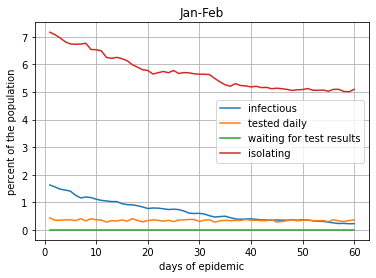

In [8]:
from codit.outbreak_recorder import WardComponent

DAYS_MONTH = 30

o_Jan_Feb = Outbreak(soc, n_days=DAYS_MONTH * 2, population=pop, reset_population=False)
o_Jan_Feb.recorder.add_component(WardComponent(o_Jan_Feb))
o_Jan_Feb.simulate()
o_Jan_Feb.recorder.plot(title="Jan-Feb")

### March 
  1. Open classrooms
  2. People now 'brush past' on average 0.3 others randomly per day (see COMIX)
  3. Vaccinate the over 60s

In [9]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.66, ephemeral_contact=0.3)

pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)
pop.clear_memory()

for i, p in enumerate(pop.people):
    if p.age > 60 and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

2021-05-16 17:03:42.819 INFO     66.0% of workplaces closed by lockdown, leaving 1677 open, of average Income Decile 4.90 (and st dev 3.12).
2021-05-16 17:03:42.829 INFO     0.0% of classrooms closed by lockdown, leaving 189 open, of average Income Decile 4.70 (and st dev 3.09).
2021-05-16 17:03:42.831 INFO     Adding 17341 permanent contact groups
2021-05-16 17:03:42.840 INFO     Adding 5948 ephemeral contact pairs
2021-05-16 17:03:42.888 INFO     Adding 11418 contacts each within one of the 8342 buildings (contact density of 0.75)


2021-05-16 17:03:44.772 INFO     Day 1, prop infected is 0.16, prop infectious is 0.0020
2021-05-16 17:03:49.162 INFO     Day 30, prop infected is 0.16, prop infectious is 0.0004
2021-05-16 17:03:49.260 INFO      Realized R0 of early infections is 0.84
2021-05-16 17:03:49.261 INFO      16.4 percent of the population was infected during the epidemic


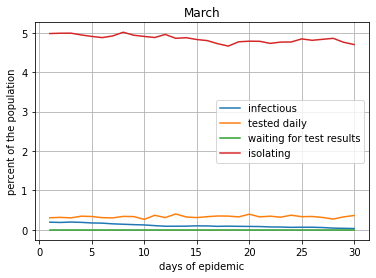

In [10]:
o_March = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_March.recorder.add_component(WardComponent(o_March))
o_March.simulate()
o_March.recorder.plot(title="March")

### April
    1. More workplaces (such as non-essential retail) open up
    2. More people brush past each other as restrictions are lifted
    3. 10 people introduce the Indian variant into the Leeds population
    4. Vaccinate the over 50s

In [11]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.5, ephemeral_contact=0.4)

pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)

pop.seed_infections(10, indian_variant)
pop.clear_memory()

for i, p in enumerate(pop.people):
    if (60 >= p.age > 50) and i % 20: # vaccinate 19 in every 20 people
        p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

2021-05-16 17:03:49.590 INFO     50.0% of workplaces closed by lockdown, leaving 2404 open, of average Income Decile 4.90 (and st dev 3.11).
2021-05-16 17:03:49.603 INFO     0.0% of classrooms closed by lockdown, leaving 189 open, of average Income Decile 4.73 (and st dev 3.14).
2021-05-16 17:03:49.604 INFO     Adding 18068 permanent contact groups
2021-05-16 17:03:49.616 INFO     Adding 7931 ephemeral contact pairs
2021-05-16 17:03:49.665 INFO     Adding 11374 contacts each within one of the 8342 buildings (contact density of 0.75)


2021-05-16 17:03:51.531 INFO     Day 1, prop infected is 0.16, prop infectious is 0.0006
2021-05-16 17:03:56.111 INFO     Day 30, prop infected is 0.17, prop infectious is 0.0009
2021-05-16 17:03:56.205 INFO      Realized R0 of early infections is 1.15
2021-05-16 17:03:56.206 INFO      16.9 percent of the population was infected during the epidemic


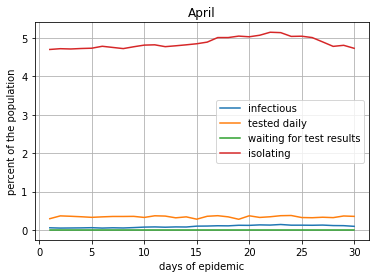

In [12]:
o_April = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_April.recorder.add_component(WardComponent(o_April))
o_April.simulate()
o_April.recorder.plot(title="April")

### May
    1. Even more workplaces open up
    2. More people brush past on average 0.5 others randomly per day


In [13]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.33, ephemeral_contact=0.5)
pop.clear_memory()
pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)

for i, p in enumerate(pop.people):
    if (50 >= p.age > 45) and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

2021-05-16 17:03:56.540 INFO     33.0% of workplaces closed by lockdown, leaving 3026 open, of average Income Decile 4.93 (and st dev 3.11).
2021-05-16 17:03:56.550 INFO     0.0% of classrooms closed by lockdown, leaving 191 open, of average Income Decile 4.71 (and st dev 3.10).
2021-05-16 17:03:56.552 INFO     Adding 18692 permanent contact groups
2021-05-16 17:03:56.604 INFO     Adding 9914 ephemeral contact pairs
2021-05-16 17:03:56.651 INFO     Adding 11499 contacts each within one of the 8342 buildings (contact density of 0.75)


### Surge Vaccinations all people over 16?

In [14]:
# for p in pop.people:
#     if p.age > 16:
#         p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

2021-05-16 17:03:58.819 INFO     Day 1, prop infected is 0.17, prop infectious is 0.0010
2021-05-16 17:04:03.502 INFO     Day 30, prop infected is 0.18, prop infectious is 0.0018
2021-05-16 17:04:03.602 INFO      Realized R0 of early infections is 0.98
2021-05-16 17:04:03.603 INFO      17.5 percent of the population was infected during the epidemic


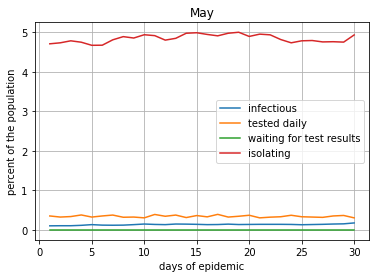

In [15]:
o_May = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_May.recorder.add_component(WardComponent(o_May))
o_May.simulate()
o_May.recorder.plot(title="May")